In [1]:
import pandas as pd
import numpy as np
import os
import sys 
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [3]:
abs = os.getcwd()
abs = abs.replace("\\src\\Time_series\\food_consump","")
sys.path.insert(0, abs   + "\\utils") 

In [4]:
from time_series import split_train_test_validation
from common import process_check
from common import process_normal
from common import process_standard
from common import process_labelencode
from common import RandomizedSCV
from common import corr_mat
from common import co_mat

In [5]:
df = pd.read_csv(abs + "/dataset/Time_series/food_consump/df.csv")

In [6]:
df.columns

Index(['Unnamed: 0', 'week', 'category', 'city_code', 'checkout_price',
       'base_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'op_area', 'region_code', 'meal_id', 'center_id',
       'cuisine'],
      dtype='object')

In [44]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [45]:
df.head()

,week,category,city_code,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,region_code,meal_id,center_id,cuisine
0,1,Beverages,647,251.23,252.23,0,0,28,2.0,56,1248,55,Indian
1,2,Beverages,647,96.06,253.23,1,0,257,2.0,56,1248,55,Indian
2,3,Beverages,647,94.12,252.23,0,0,68,2.0,56,1248,55,Indian
3,4,Beverages,647,97.00,252.23,0,0,96,2.0,56,1248,55,Indian
4,5,Beverages,647,97.00,252.23,0,0,27,2.0,56,1248,55,Indian


In [46]:
df.drop(columns = ['category', 'city_code', 'homepage_featured',
        'op_area', 'region_code', 'meal_id', 'center_id',
       'cuisine'], inplace = True)

In [47]:
df.head()

,week,checkout_price,base_price,emailer_for_promotion,num_orders
0,1,251.23,252.23,0,28
1,2,96.06,253.23,1,257
2,3,94.12,252.23,0,68
3,4,97.00,252.23,0,96
4,5,97.00,252.23,0,27


In [48]:
df1 = df[['week','num_orders']]
df1.head()

,week,num_orders
0,1,28
1,2,257
2,3,68
3,4,96
4,5,27


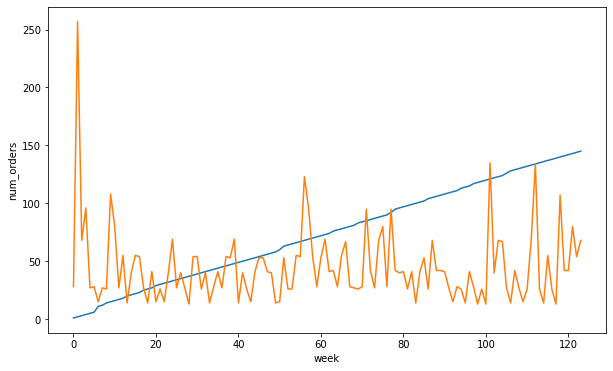

In [49]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('week')
plt.ylabel('num_orders')
plt.plot(df1)

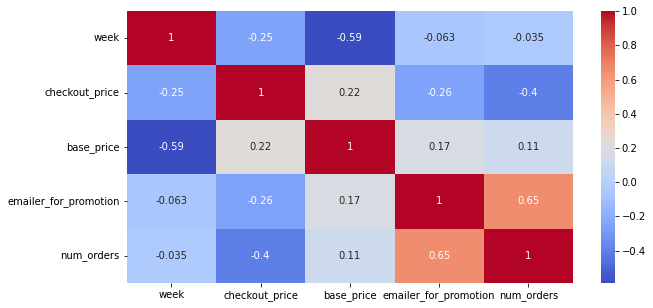

In [50]:
corr_mat(df)

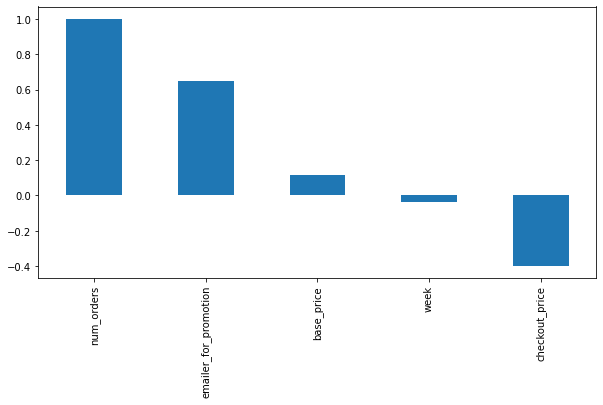

In [51]:
co_mat(df, 'num_orders')

In [52]:
df.corr()['num_orders'].abs().sort_values(ascending=False)

num_orders               1.000000
emailer_for_promotion    0.647745
checkout_price           0.398908
base_price               0.113914
week                     0.035288
Name: num_orders, dtype: float64

In [53]:
df.columns

Index(['week', 'checkout_price', 'base_price', 'emailer_for_promotion',
       'num_orders'],
      dtype='object')

In [54]:
df1 = df[['week', 'checkout_price', 'base_price', 'emailer_for_promotion',
       'num_orders']]

In [55]:
sca, norm = process_check(df1)

In [56]:
print(sca, norm)

['week'] ['checkout_price', 'base_price', 'emailer_for_promotion', 'num_orders']


In [57]:
norm = ['checkout_price', 'base_price']

In [58]:
df1[sca], standardise_ind = process_standard(df1, sca)
df1[norm], normalise_ind = process_normal(df1, norm)

In [59]:
norm = ['num_orders']
df1[norm], normalise_ind_num = process_normal(df1, norm)

In [60]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_validation(df1, 0.1, 0.05, 'num_orders')

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = train.drop([label], 1)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_valid = valid.drop([label], 1)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test  = test.drop([label], 1)


In [61]:
parameters = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [ 0.005, 0.01, 0.05],
    'max_depth': [8, 9, 10, 11],
    'gamma': [0.005, 0.01, 0.1],
    'random_state': [42]
}

param_size = ParameterGrid(parameters)
len(param_size)

144

In [62]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]
gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'eval_set': 'eval_set',
     'verbose': False,
     
}

In [63]:
%%time
model = xgb.XGBRegressor(**gpu_dict)
random_result = RandomizedSCV(model,parameters,1, -1, len(param_size)-4, X_train, y_train)

print('Best Score: ', random_result.best_score_*100)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[15:31:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "eval_set", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Score:  32.812613217857276
Best Params:  {'random_state': 42, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.01}
CPU times: total: 3.89 s
Wall time: 2min 10s


In [64]:
%%time

model = xgb.XGBRegressor(**random_result.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: total: 1.03 s
Wall time: 434 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [65]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)}')
print(f'y_pred = {y_pred}')

y_true = [0.49590164 0.05327869 0.00409836 0.17213115 0.05327869 0.
 0.3852459  0.11885246 0.11885246 0.27459016 0.16803279 0.22540984]
y_pred = [0.3937464  0.22284862 0.14997014 0.14997014 0.18819228 0.18819228
 0.14997014 0.11618851 0.11618851 0.11618851 0.11618851 0.11618851]


In [66]:
y_t = np.array(y_test)

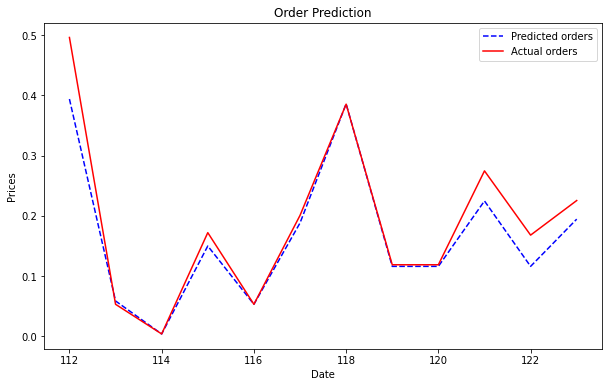

In [68]:
test_set_range = y_test.index
plt.plot(test_set_range, y_pred, color='blue', linestyle='dashed',label='Predicted orders')
plt.plot(test_set_range, y_t, color='red', label='Actual orders')
plt.title('Order Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [69]:
mape = np.mean(np.abs((y_t - y_pred) / y_t))*100
mape

9.889854159328062

In [70]:
abs

'c:\\Users\\abulf\\Documents\\Python_tutorial\\Assignments\\Machine_learning\\ML_framework'

In [71]:
pickle.dump(model, open(abs + "\\output\\Time Series\\food_consump\\model.pkl", 'wb'))
pickle.dump(standardise_ind, open(abs + "\\output\\Time Series\\food_consump\\standardise_ind.pkl", 'wb'))
pickle.dump(normalise_ind, open(abs + "\\output\\Time Series\\food_consump\\normalise_ind.pkl", 'wb'))
pickle.dump(normalise_ind_num, open(abs + "\\output\\Time Series\\food_consump\\normalise_ind_num.pkl", 'wb'))